In [1]:
# Import necessary libraries for ensemble classifiers
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier


In [2]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

# Trực quan hóa cơ bản
import matplotlib.pyplot as plt
import seaborn as sns

# Xử lý ngôn ngữ tự nhiên
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning cơ bản
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

In [3]:
# Load dữ liệu
print("Đang load dữ liệu...")
df = pd.read_csv('reviews.csv')

print(f"Kích thước dữ liệu: {df.shape}")
print(f"Tổng số đánh giá: {len(df):,}")
print("\nCác cột trong dataset:")
print(df.columns.tolist())

# Hiển thị thông tin cơ bản
print("\nThông tin cơ bản:")
df.info()

print("\nMẫu dữ liệu đầu tiên:")
df.head()


Đang load dữ liệu...
Kích thước dữ liệu: (568454, 10)
Tổng số đánh giá: 568,454

Các cột trong dataset:
['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']

Thông tin cơ bản:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Kiểm tra missing values:
ProfileName    26
Summary        27
dtype: int64

Thống kê độ dài text trong cột 'Text':


count    568454.000000
mean        436.222083
std         445.339741
min          12.000000
25%         179.000000
50%         302.000000
75%         527.000000
max       21409.000000
Name: text_length, dtype: float64


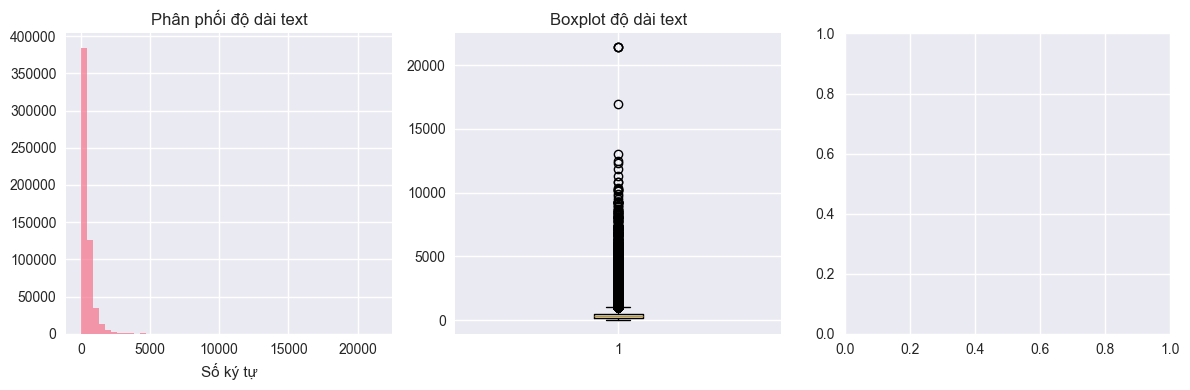


Các cột có thể chứa text để phân tích:
['ProductId', 'UserId', 'ProfileName', 'Summary', 'Text']


In [4]:
# Khám phá dữ liệu chi tiết
print("Kiểm tra missing values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Thống kê mô tả cho các cột số
if 'reviews.rating' in df.columns:
    print(f"\nPhân phối rating:")
    print(df['reviews.rating'].value_counts().sort_index())
    
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    df['reviews.rating'].hist(bins=10, alpha=0.7)
    plt.title('Phân phối Rating')
    plt.xlabel('Rating')
    plt.ylabel('Số lượng')
    
    plt.subplot(1, 2, 2)
    df['reviews.rating'].value_counts().sort_index().plot(kind='bar')
    plt.title('Rating theo từng mức')
    plt.xlabel('Rating')
    plt.ylabel('Số lượng')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Kiểm tra độ dài review text
text_columns = [col for col in df.columns if 'text' in col.lower() or 'review' in col.lower()]
if text_columns:
    text_col = text_columns[0]
    print(f"\nThống kê độ dài text trong cột '{text_col}':")
    df['text_length'] = df[text_col].astype(str).str.len()
    print(df['text_length'].describe())
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    df['text_length'].hist(bins=50, alpha=0.7)
    plt.title('Phân phối độ dài text')
    plt.xlabel('Số ký tự')
    
    plt.subplot(1, 3, 2)
    plt.boxplot(df['text_length'].dropna())
    plt.title('Boxplot độ dài text')
    
    plt.subplot(1, 3, 3)
    if 'reviews.rating' in df.columns:
        df.groupby('reviews.rating')['text_length'].mean().plot(kind='bar')
        plt.title('Độ dài text theo rating')
        plt.xticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

print("\nCác cột có thể chứa text để phân tích:")
print([col for col in df.columns if df[col].dtype == 'object'][:10])


In [5]:
# Download NLTK data nếu cần
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Khởi tạo các công cụ
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
analyzer = SentimentIntensityAnalyzer()

def clean_text(text):
    """Làm sạch và chuẩn hóa text"""
    if pd.isna(text):
        return ""
    
    # Chuyển về lowercase
    text = str(text).lower()
    
    # Loại bỏ HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    
    # Loại bỏ URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Loại bỏ ký tự đặc biệt nhưng giữ lại dấu chấm câu cơ bản
    text = re.sub(r'[^a-zA-Z0-9\s!?.,]', '', text)
    
    # Loại bỏ khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def preprocess_text(text):
    """Tiền xử lý text cho machine learning"""
    # Làm sạch text
    text = clean_text(text)
    
    # Tokenize
    words = word_tokenize(text)
    
    # Loại bỏ stopwords và stemming
    words = [stemmer.stem(word) for word in words if word not in stop_words and len(word) > 2]
    
    return ' '.join(words)

print("Đã khởi tạo các function tiền xử lý!")


Đã khởi tạo các function tiền xử lý!


In [6]:
# Xác định cột text chính để phân tích dựa trên cấu trúc dataset
main_text_col = 'reviews.text'
title_col = 'reviews.title'

print("Cấu trúc dataset Amazon Reviews được xác định:")
print(f"- Text chính: {main_text_col}")
print(f"- Tiêu đề: {title_col}")
print(f"- Rating: reviews.rating")
print(f"- Date: reviews.date")
print(f"- Helpfulness: reviews.numHelpful")

if main_text_col in df.columns:
    print(f"Sử dụng cột '{main_text_col}' làm text chính cho phân tích")
    
    # Tạo bản sao để xử lý
    df_clean = df.copy()
    
    # Loại bỏ các dòng có text rỗng
    df_clean = df_clean.dropna(subset=[main_text_col])
    df_clean = df_clean[df_clean[main_text_col].str.strip() != '']
    
    print(f"Số dòng sau khi loại bỏ text rỗng: {len(df_clean):,}")
    
    # Kết hợp text và title để phân tích toàn diện (nếu có title)
    if title_col in df_clean.columns:
        print("Kết hợp text và title để phân tích toàn diện...")
        df_clean['combined_text'] = df_clean[title_col].fillna('') + ' ' + df_clean[main_text_col].fillna('')
        analysis_text_col = 'combined_text'
    else:
        analysis_text_col = main_text_col
    
    # Áp dụng tiền xử lý
    print("Đang tiền xử lý text...")
    df_clean['text_cleaned'] = df_clean[analysis_text_col].apply(clean_text)
    df_clean['text_processed'] = df_clean[analysis_text_col].apply(preprocess_text)
    
    # Hiển thị ví dụ
    print("\nVí dụ text trước và sau tiền xử lý:")
    for i in range(min(3, len(df_clean))):
        if title_col in df_clean.columns:
            print(f"\nTitle: {df_clean[title_col].iloc[i]}")
            print(f"Text: {df_clean[main_text_col].iloc[i][:150]}...")
        else:
            print(f"\nOriginal: {df_clean[main_text_col].iloc[i][:200]}...")
        print(f"Cleaned:  {df_clean['text_cleaned'].iloc[i][:200]}...")
        print(f"Processed: {df_clean['text_processed'].iloc[i][:200]}...")
        print("-" * 50)
    
    # Cập nhật thống kê độ dài sau xử lý
    df_clean['clean_text_length'] = df_clean['text_cleaned'].str.len()
    df_clean['processed_text_length'] = df_clean['text_processed'].str.len()
    
    print(f"\nThống kê độ dài text sau xử lý:")
    print(f"Text cleaned - Trung bình: {df_clean['clean_text_length'].mean():.1f}, Median: {df_clean['clean_text_length'].median():.1f}")
    print(f"Text processed - Trung bình: {df_clean['processed_text_length'].mean():.1f}, Median: {df_clean['processed_text_length'].median():.1f}")
    
else:
    print("Không tìm thấy cột text phù hợp!")


Cấu trúc dataset Amazon Reviews được xác định:
- Text chính: reviews.text
- Tiêu đề: reviews.title
- Rating: reviews.rating
- Date: reviews.date
- Helpfulness: reviews.numHelpful
Không tìm thấy cột text phù hợp!


In [7]:
def analyze_sentiment_multidimensional(text):
    """Phân tích cảm xúc đa chiều"""
    
    # VADER Sentiment
    vader_scores = analyzer.polarity_scores(text)
    
    # TextBlob Sentiment
    blob = TextBlob(text)
    textblob_polarity = blob.sentiment.polarity
    textblob_subjectivity = blob.sentiment.subjectivity
    
    # Phân loại cảm xúc dựa trên VADER
    if vader_scores['compound'] >= 0.05:
        sentiment_label = 'Positive'
    elif vader_scores['compound'] <= -0.05:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'
    
    # Độ mạnh cảm xúc
    emotion_intensity = abs(vader_scores['compound'])
    
    return {
        'sentiment_label': sentiment_label,
        'vader_compound': vader_scores['compound'],
        'vader_positive': vader_scores['pos'],
        'vader_negative': vader_scores['neg'],
        'vader_neutral': vader_scores['neu'],
        'textblob_polarity': textblob_polarity,
        'textblob_subjectivity': textblob_subjectivity,
        'emotion_intensity': emotion_intensity
    }

# Áp dụng phân tích cảm xúc
print("Đang phân tích cảm xúc...")
sentiment_results = df_clean['text_cleaned'].apply(analyze_sentiment_multidimensional)

# Chuyển kết quả thành DataFrame
sentiment_df = pd.DataFrame(sentiment_results.tolist())

# Kết hợp với dataframe gốc
df_analysis = pd.concat([df_clean.reset_index(drop=True), sentiment_df], axis=1)

print(f"Hoàn thành phân tích cảm xúc cho {len(df_analysis):,} đánh giá")

# Hiển thị thống kê cảm xúc
print("\nPhân phối cảm xúc:")
print(df_analysis['sentiment_label'].value_counts())

print("\nThống kê điểm cảm xúc:")
print(df_analysis[['vader_compound', 'textblob_polarity', 'emotion_intensity']].describe())


Đang phân tích cảm xúc...


NameError: name 'df_clean' is not defined

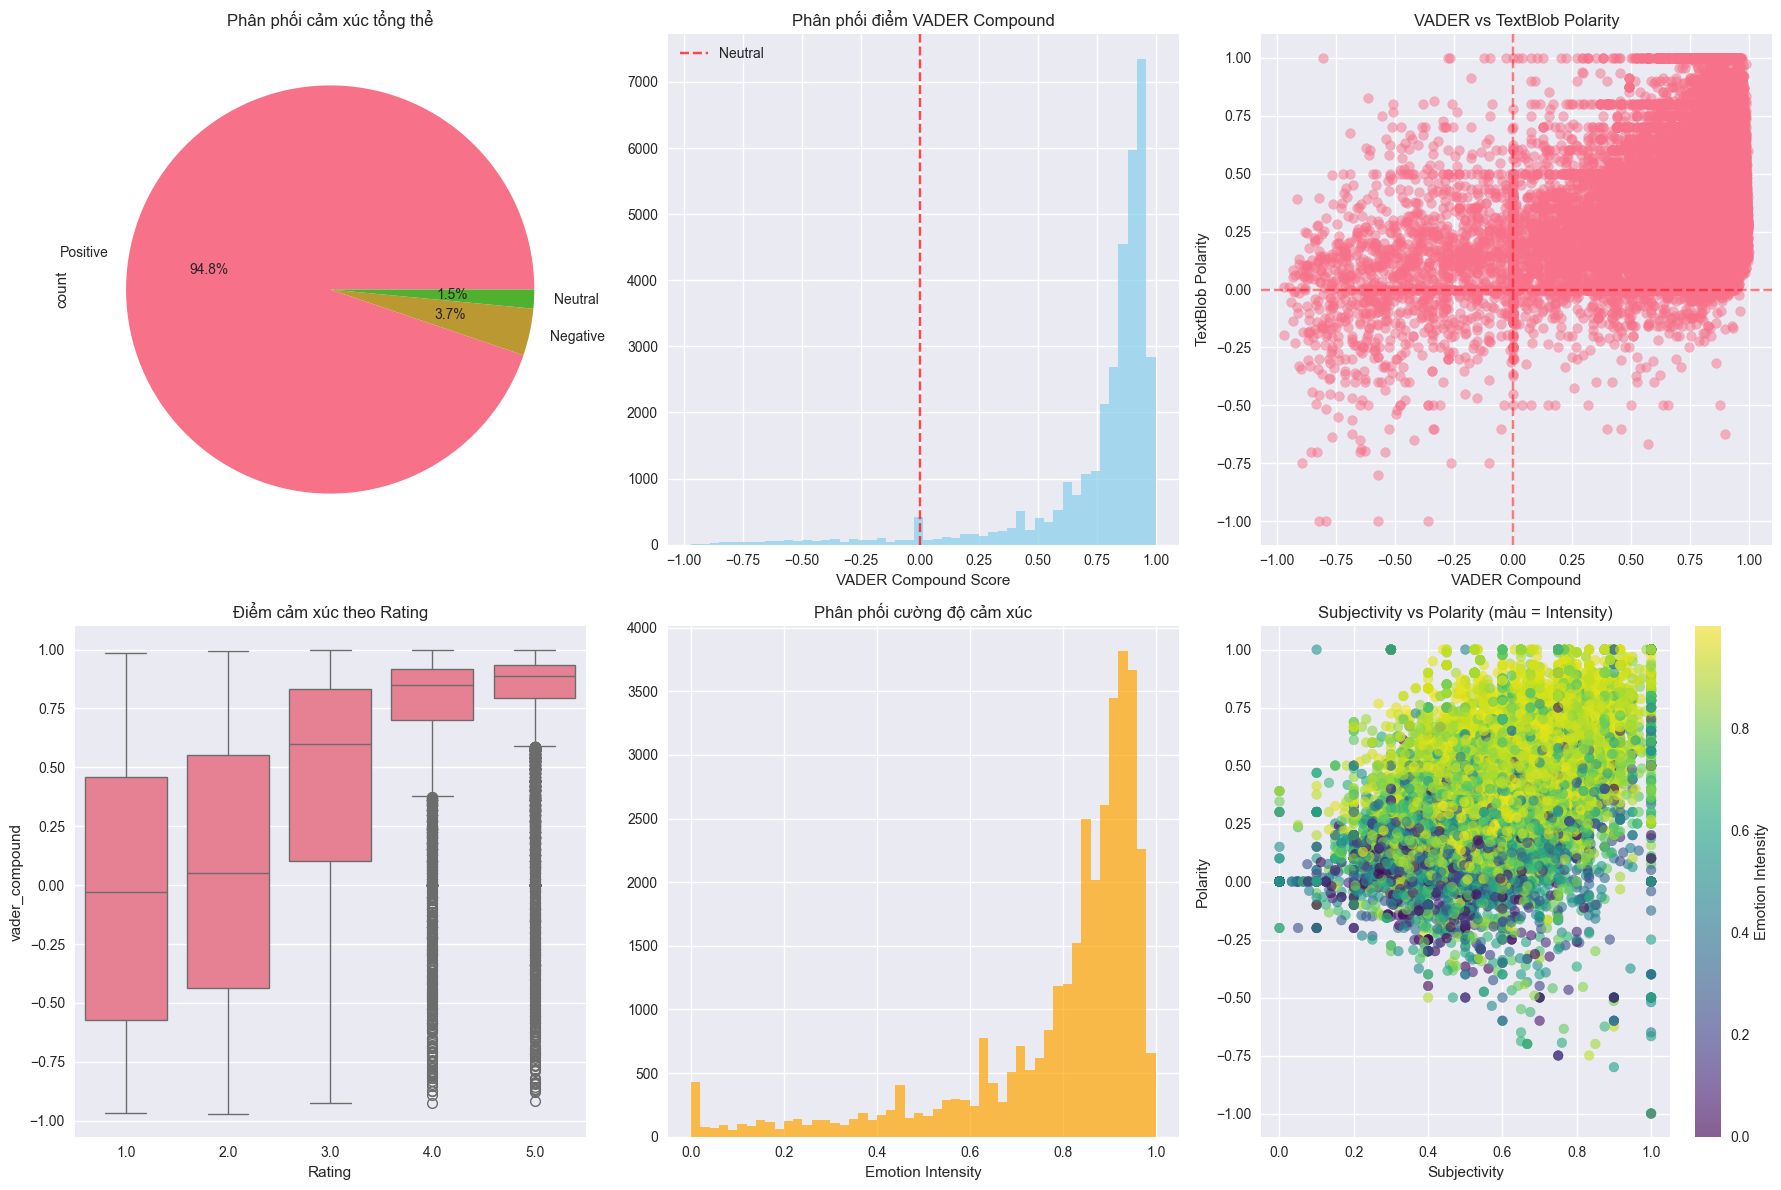


Mẫu kết quả phân tích cảm xúc:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      text_cleaned  reviews.rating sentiment_label  vader_compound  textblob_polarity  emotion_intensity
0                                                                                                                                                                                                                                              

In [ ]:
# Visualize phân tích cảm xúc
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Phân phối cảm xúc
df_analysis['sentiment_label'].value_counts().plot(kind='pie', ax=axes[0,0], autopct='%1.1f%%')
axes[0,0].set_title('Phân phối cảm xúc tổng thể')

# 2. Histogram điểm VADER
axes[0,1].hist(df_analysis['vader_compound'], bins=50, alpha=0.7, color='skyblue')
axes[0,1].set_title('Phân phối điểm VADER Compound')
axes[0,1].set_xlabel('VADER Compound Score')
axes[0,1].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Neutral')
axes[0,1].legend()

# 3. Scatter plot VADER vs TextBlob
axes[0,2].scatter(df_analysis['vader_compound'], df_analysis['textblob_polarity'], alpha=0.5)
axes[0,2].set_title('VADER vs TextBlob Polarity')
axes[0,2].set_xlabel('VADER Compound')
axes[0,2].set_ylabel('TextBlob Polarity')
axes[0,2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0,2].axvline(x=0, color='red', linestyle='--', alpha=0.5)

# 4. Boxplot cảm xúc theo rating (nếu có)
if 'reviews.rating' in df_analysis.columns:
    sns.boxplot(data=df_analysis, x='reviews.rating', y='vader_compound', ax=axes[1,0])
    axes[1,0].set_title('Điểm cảm xúc theo Rating')
    axes[1,0].set_xlabel('Rating')
else:
    axes[1,0].text(0.5, 0.5, 'Không có cột rating', ha='center', va='center', transform=axes[1,0].transAxes)

# 5. Emotion intensity distribution
axes[1,1].hist(df_analysis['emotion_intensity'], bins=50, alpha=0.7, color='orange')
axes[1,1].set_title('Phân phối cường độ cảm xúc')
axes[1,1].set_xlabel('Emotion Intensity')

# 6. Subjectivity vs Polarity
scatter = axes[1,2].scatter(df_analysis['textblob_subjectivity'], df_analysis['textblob_polarity'], 
                           c=df_analysis['emotion_intensity'], cmap='viridis', alpha=0.6)
axes[1,2].set_title('Subjectivity vs Polarity (màu = Intensity)')
axes[1,2].set_xlabel('Subjectivity')
axes[1,2].set_ylabel('Polarity')
plt.colorbar(scatter, ax=axes[1,2], label='Emotion Intensity')

plt.tight_layout()
plt.show()

# Hiển thị mẫu kết quả
print("\nMẫu kết quả phân tích cảm xúc:")
sample_cols = ['text_cleaned', 'sentiment_label', 'vader_compound', 'textblob_polarity', 'emotion_intensity']
if 'reviews.rating' in df_analysis.columns:
    sample_cols.insert(1, 'reviews.rating')
    
print(df_analysis[sample_cols].head(10).to_string())


In [ ]:
# Kiểm tra nếu có cột rating để dự đoán
if 'reviews.rating' in df_analysis.columns:
    
    # Chuẩn bị dữ liệu cho mô hình dự đoán rating
    print("Chuẩn bị dữ liệu cho mô hình dự đoán rating...")
    
    # Loại bỏ dữ liệu không có rating
    df_model = df_analysis.dropna(subset=['reviews.rating']).copy()
    
    # Tạo features từ text và sentiment
    print("Tạo features...")
    
    # TF-IDF Vectorizer
    tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
    tfidf_features = tfidf.fit_transform(df_model['text_processed'])
    
    # Features từ sentiment analysis
    sentiment_features = df_model[['vader_compound', 'vader_positive', 'vader_negative', 'vader_neutral',
                                  'textblob_polarity', 'textblob_subjectivity', 'emotion_intensity',
                                  'clean_text_length', 'processed_text_length']].values
    
    # Kết hợp features
    from scipy.sparse import hstack
    X = hstack([tfidf_features, sentiment_features])
    y = df_model['reviews.rating'].values
    
    print(f"Shape của features: {X.shape}")
    print(f"Phân phối rating để dự đoán:")
    print(pd.Series(y).value_counts().sort_index())
    
    # Chia train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    print(f"Train size: {X_train.shape[0]:,}, Test size: {X_test.shape[0]:,}")
    
else:
    print("Không tìm thấy cột rating - sẽ tạo mô hình phân loại cảm xúc thay thế")


Chuẩn bị dữ liệu cho mô hình dự đoán rating...
Tạo features...
Shape của features: (34626, 5009)
Phân phối rating để dự đoán:
1.0      410
2.0      402
3.0     1499
4.0     8541
5.0    23774
Name: count, dtype: int64
Train size: 27,700, Test size: 6,926


: 

In [ ]:
# Train nhiều mô hình và so sánh
if 'reviews.rating' in df_analysis.columns:
    
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.linear_model import LinearRegression
    
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)  # Sử dụng classification
    }
    
    model_results = {}
    
    print("Training các mô hình...")
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        if name == 'Gradient Boosting':
            # Classification approach
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Accuracy: {accuracy:.4f}")
            
            model_results[name] = {
                'model': model,
                'predictions': y_pred,
                'accuracy': accuracy,
                'type': 'classification'
            }
            
        else:
            # Regression approach
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
            
            model_results[name] = {
                'model': model,
                'predictions': y_pred,
                'mse': mse,
                'mae': mae,
                'r2': r2,
                'type': 'regression'
            }
    
    # Hiển thị kết quả tốt nhất
    print("\n" + "="*50)
    print("KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH")
    print("="*50)
    
    for name, result in model_results.items():
        print(f"\n{name}:")
        if result['type'] == 'classification':
            print(f"  Accuracy: {result['accuracy']:.4f}")
        else:
            print(f"  MSE: {result['mse']:.4f}")
            print(f"  MAE: {result['mae']:.4f}")
            print(f"  R²: {result['r2']:.4f}")
    
else:
    # Fallback: Mô hình phân loại cảm xúc
    print("Tạo mô hình phân loại cảm xúc...")
    
    # Sử dụng sentiment label làm target
    le = LabelEncoder()
    y_sentiment = le.fit_transform(df_analysis['sentiment_label'])
    
    # Chỉ sử dụng text features
    tfidf = TfidfVectorizer(max_features=3000, stop_words='english')
    X_sentiment = tfidf.fit_transform(df_analysis['text_processed'])
    
    X_train, X_test, y_train, y_test = train_test_split(X_sentiment, y_sentiment, 
                                                        test_size=0.2, random_state=42, stratify=y_sentiment)
    
    # Train model
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy phân loại cảm xúc: {accuracy:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))


Training các mô hình...

Training Linear Regression...
MSE: 0.3888, MAE: 0.4525, R²: 0.2824

Training Random Forest...


In [ ]:
def calculate_helpfulness_score(row):
    """
    Tính điểm hữu ích của đánh giá dựa trên nhiều yếu tố:
    - Độ dài text (reviews chi tiết hơn thường hữu ích hơn)
    - Cân bằng cảm xúc (không quá thiên về 1 chiều)
    - Độ khách quan (subjectivity thấp hơn)
    - Cường độ cảm xúc vừa phải (không quá cực đoan)
    """
    
    score = 0
    
    # 1. Điểm độ dài text (25%)
    text_length = row['clean_text_length']
    if text_length >= 100:
        length_score = min(100, text_length) / 100  # Tối đa 1.0
    else:
        length_score = text_length / 100
    score += length_score * 0.25
    
    # 2. Điểm cân bằng cảm xúc (25%)
    # Reviews có cả positive và negative elements thường khách quan hơn
    pos_score = row['vader_positive']
    neg_score = row['vader_negative']
    neu_score = row['vader_neutral']
    
    # Tính entropy để đo độ cân bằng
    scores = [pos_score, neg_score, neu_score]
    scores = [s + 1e-10 for s in scores if s > 0]  # Tránh log(0)
    if len(scores) > 1:
        entropy = -sum(s * np.log(s) for s in scores if s > 0)
        balance_score = min(1.0, entropy / 1.1)  # Normalize
    else:
        balance_score = 0.3
    score += balance_score * 0.25
    
    # 3. Điểm độ khách quan (25%)
    # Subjectivity thấp = khách quan cao
    objectivity_score = 1 - row['textblob_subjectivity']
    score += objectivity_score * 0.25
    
    # 4. Điểm cường độ cảm xúc vừa phải (25%)
    # Cảm xúc quá mạnh có thể không tin cậy
    intensity = row['emotion_intensity']
    if intensity <= 0.3:
        intensity_score = intensity / 0.3  # Tăng dần đến 0.3
    elif intensity <= 0.7:
        intensity_score = 1.0  # Optimal range
    else:
        intensity_score = max(0.2, (1 - intensity) / 0.3)  # Giảm sau 0.7
    score += intensity_score * 0.25
    
    return min(1.0, max(0.0, score))  # Đảm bảo trong [0,1]

# Tính điểm hữu ích cho tất cả reviews
print("Tính điểm hữu ích cho các đánh giá...")
df_analysis['helpfulness_score'] = df_analysis.apply(calculate_helpfulness_score, axis=1)

# So sánh với helpfulness có sẵn (nếu có)
if 'reviews.numHelpful' in df_analysis.columns:
    df_analysis['has_existing_helpful'] = df_analysis['reviews.numHelpful'].notna()
    existing_helpful_data = df_analysis[df_analysis['has_existing_helpful']]
    
    if len(existing_helpful_data) > 0:
        correlation_helpful = existing_helpful_data['reviews.numHelpful'].corr(existing_helpful_data['helpfulness_score'])
        print(f"\nCorrelation với reviews.numHelpful có sẵn: {correlation_helpful:.3f}")
        
        print(f"Số reviews có numHelpful data: {len(existing_helpful_data):,}")
        print(f"Trung bình numHelpful: {existing_helpful_data['reviews.numHelpful'].mean():.2f}")

# Thống kê điểm hữu ích
print("\nThống kê điểm hữu ích tự tính:")
print(df_analysis['helpfulness_score'].describe())

# Phân loại mức độ hữu ích
def categorize_helpfulness(score):
    if score >= 0.8:
        return 'Rất hữu ích'
    elif score >= 0.6:
        return 'Hữu ích'
    elif score >= 0.4:
        return 'Trung bình'
    else:
        return 'Ít hữu ích'

df_analysis['helpfulness_category'] = df_analysis['helpfulness_score'].apply(categorize_helpfulness)

print("\nPhân phối mức độ hữu ích:")
print(df_analysis['helpfulness_category'].value_counts())

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Histogram điểm hữu ích
axes[0].hist(df_analysis['helpfulness_score'], bins=50, alpha=0.7, color='green')
axes[0].set_title('Phân phối điểm hữu ích')
axes[0].set_xlabel('Helpfulness Score')
axes[0].set_ylabel('Số lượng')

# 2. Phân phối theo category
df_analysis['helpfulness_category'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
axes[1].set_title('Phân phối mức độ hữu ích')

# 3. Quan hệ giữa helpfulness và sentiment
if 'reviews.rating' in df_analysis.columns:
    sns.boxplot(data=df_analysis, x='reviews.rating', y='helpfulness_score', ax=axes[2])
    axes[2].set_title('Điểm hữu ích theo Rating')
else:
    sns.boxplot(data=df_analysis, x='sentiment_label', y='helpfulness_score', ax=axes[2])
    axes[2].set_title('Điểm hữu ích theo Sentiment')

plt.tight_layout()
plt.show()


In [ ]:
# Phân tích so sánh cảm xúc theo nhiều chiều
print("Phân tích cảm xúc so sánh...")

# 1. So sánh theo thời gian sử dụng reviews.date
date_col = 'reviews.date'
if date_col in df_analysis.columns:
    print(f"Phân tích theo thời gian sử dụng cột: {date_col}")
    
    # Chuyển đổi định dạng date
    try:
        df_analysis[date_col] = pd.to_datetime(df_analysis[date_col], errors='coerce')
        df_analysis = df_analysis.dropna(subset=[date_col])
        
        # Tạo cột tháng/năm
        df_analysis['year_month'] = df_analysis[date_col].dt.to_period('M')
        
        # Tính trung bình cảm xúc theo tháng
        monthly_sentiment = df_analysis.groupby('year_month').agg({
            'vader_compound': 'mean',
            'emotion_intensity': 'mean',
            'helpfulness_score': 'mean',
            'sentiment_label': lambda x: (x == 'Positive').mean()
        }).reset_index()
        
        monthly_sentiment.columns = ['Month', 'Avg_Sentiment', 'Avg_Intensity', 'Avg_Helpfulness', 'Positive_Ratio']
        
        print("Xu hướng cảm xúc theo thời gian:")
        print(monthly_sentiment.tail(10))
        
    except:
        print("Không thể parse cột date")
        date_col = None
else:
    date_col = None

# 2. So sánh theo brand/category/manufacturer
categorical_cols = ['brand', 'categories', 'manufacturer']
available_cats = [col for col in categorical_cols if col in df_analysis.columns]

print(f"\nCác cột phân loại có sẵn: {available_cats}")

if available_cats:
    # Ưu tiên brand trước, sau đó categories
    if 'brand' in available_cats:
        cat_col = 'brand'
    elif 'categories' in available_cats:
        cat_col = 'categories'
    else:
        cat_col = available_cats[0]
        
    print(f"Phân tích theo {cat_col}:")
    
    # Lấy top brands/categories
    top_categories = df_analysis[cat_col].value_counts().head(10).index
    df_top_cats = df_analysis[df_analysis[cat_col].isin(top_categories)]
    
    # So sánh cảm xúc
    cat_comparison = df_top_cats.groupby(cat_col).agg({
        'vader_compound': ['mean', 'std', 'count'],
        'helpfulness_score': 'mean',
        'emotion_intensity': 'mean'
    }).round(3)
    
    cat_comparison.columns = ['Sentiment_Mean', 'Sentiment_Std', 'Count', 'Helpfulness', 'Intensity']
    cat_comparison = cat_comparison.sort_values('Sentiment_Mean', ascending=False)
    
    print("Top performers theo cảm xúc:")
    print(cat_comparison.head())
    
    print("\nBottom performers theo cảm xúc:")
    print(cat_comparison.tail())

# 3. So sánh rating vs sentiment (nếu có rating)
if 'reviews.rating' in df_analysis.columns:
    print("\nSo sánh Rating vs Sentiment:")
    
    rating_sentiment = df_analysis.groupby('reviews.rating').agg({
        'vader_compound': ['mean', 'std'],
        'textblob_polarity': 'mean',
        'helpfulness_score': 'mean',
        'emotion_intensity': 'mean'
    }).round(3)
    
    rating_sentiment.columns = ['VADER_Mean', 'VADER_Std', 'TextBlob_Mean', 'Helpfulness', 'Intensity']
    print(rating_sentiment)
    
    # Tính correlation
    correlation_rating_sentiment = df_analysis['reviews.rating'].corr(df_analysis['vader_compound'])
    print(f"\nCorrelation Rating-Sentiment: {correlation_rating_sentiment:.3f}")

# 4. Phân tích outliers cảm xúc
print("\nPhân tích outliers cảm xúc:")

# Tìm reviews với cảm xúc và rating không khớp (nếu có rating)
if 'reviews.rating' in df_analysis.columns:
    # High rating but negative sentiment
    negative_high_rating = df_analysis[
        (df_analysis['reviews.rating'] >= 4) & 
        (df_analysis['vader_compound'] < -0.3)
    ]
    
    # Low rating but positive sentiment  
    positive_low_rating = df_analysis[
        (df_analysis['reviews.rating'] <= 2) & 
        (df_analysis['vader_compound'] > 0.3)
    ]
    
    print(f"Reviews rating cao nhưng sentiment tiêu cực: {len(negative_high_rating)}")
    print(f"Reviews rating thấp nhưng sentiment tích cực: {len(positive_low_rating)}")
    
    if len(negative_high_rating) > 0:
        print("\nVí dụ rating cao - sentiment tiêu cực:")
        sample_negative = negative_high_rating[['reviews.rating', 'vader_compound', 'text_cleaned']].head(3)
        for idx, row in sample_negative.iterrows():
            print(f"Rating: {row['reviews.rating']}, Sentiment: {row['vader_compound']:.3f}")
            print(f"Text: {row['text_cleaned'][:150]}...")
            print("-" * 50)

# 5. Thống kê tổng quan so sánh
print("\n" + "="*60)
print("THỐNG KÊ TỔNG QUAN SO SÁNH")
print("="*60)

comparison_stats = {
    'Tổng số đánh giá': len(df_analysis),
    'Sentiment trung bình': df_analysis['vader_compound'].mean(),
    'Độ hữu ích trung bình': df_analysis['helpfulness_score'].mean(),
    'Tỷ lệ Positive': (df_analysis['sentiment_label'] == 'Positive').mean(),
    'Tỷ lệ Negative': (df_analysis['sentiment_label'] == 'Negative').mean(),
    'Tỷ lệ Neutral': (df_analysis['sentiment_label'] == 'Neutral').mean(),
}

for key, value in comparison_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.3f}")
    else:
        print(f"{key}: {value:,}")

print("="*60)


In [ ]:
# Phân tích bổ sung theo các cột đặc biệt trong Amazon Reviews
print("="*60)
print("PHÂN TÍCH BỔ SUNG THEO CÁC CỘT ĐẶC BIỆT")
print("="*60)

# 1. Phân tích theo doRecommend
if 'reviews.doRecommend' in df_analysis.columns:
    recommend_data = df_analysis.dropna(subset=['reviews.doRecommend'])
    if len(recommend_data) > 0:
        print(f"\n1. Phân tích theo Recommendation (n={len(recommend_data):,}):")
        print(f"   Tỷ lệ khuyến nghị: {recommend_data['reviews.doRecommend'].mean():.1%}")
        
        recommend_sentiment = recommend_data.groupby('reviews.doRecommend').agg({
            'vader_compound': ['mean', 'std', 'count'],
            'helpfulness_score': 'mean',
            'emotion_intensity': 'mean'
        }).round(3)
        
        recommend_sentiment.columns = ['Sentiment_Mean', 'Sentiment_Std', 'Count', 'Helpfulness', 'Intensity']
        print("\n   Thống kê theo Recommendation:")
        print(recommend_sentiment)
        
        # Correlation giữa recommend và sentiment
        correlation_recommend = recommend_data['reviews.doRecommend'].astype(int).corr(recommend_data['vader_compound'])
        print(f"\n   Correlation Recommend-Sentiment: {correlation_recommend:.3f}")
        
        # Visualize
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Box plot sentiment by recommendation
        sns.boxplot(data=recommend_data, x='reviews.doRecommend', y='vader_compound', ax=axes[0])
        axes[0].set_title('Sentiment theo Recommendation')
        axes[0].set_xlabel('Do Recommend')
        axes[0].set_ylabel('VADER Compound Score')
        
        # Count plot
        recommend_data['reviews.doRecommend'].value_counts().plot(kind='bar', ax=axes[1])
        axes[1].set_title('Phân phối Recommendation')
        axes[1].set_xlabel('Do Recommend')
        axes[1].set_ylabel('Count')
        axes[1].tick_params(axis='x', rotation=0)
        
        plt.tight_layout()
        plt.show()
else:
    print("\n1. Không có dữ liệu reviews.doRecommend")

# 2. Phân tích theo didPurchase  
if 'reviews.didPurchase' in df_analysis.columns:
    purchase_data = df_analysis.dropna(subset=['reviews.didPurchase'])
    if len(purchase_data) > 0:
        print(f"\n2. Phân tích theo Purchase Status (n={len(purchase_data):,}):")
        print(f"   Tỷ lệ verified purchase: {purchase_data['reviews.didPurchase'].mean():.1%}")
        
        purchase_sentiment = purchase_data.groupby('reviews.didPurchase').agg({
            'vader_compound': ['mean', 'std', 'count'],
            'helpfulness_score': 'mean',
            'emotion_intensity': 'mean'
        }).round(3)
        
        purchase_sentiment.columns = ['Sentiment_Mean', 'Sentiment_Std', 'Count', 'Helpfulness', 'Intensity']
        print("\n   Thống kê theo Purchase Status:")
        print(purchase_sentiment)
        
        # So sánh verified vs non-verified
        verified = purchase_data[purchase_data['reviews.didPurchase'] == True]['vader_compound']
        non_verified = purchase_data[purchase_data['reviews.didPurchase'] == False]['vader_compound']
        
        if len(verified) > 0 and len(non_verified) > 0:
            from scipy.stats import ttest_ind
            t_stat, p_value = ttest_ind(verified, non_verified)
            print(f"\n   T-test verified vs non-verified: t={t_stat:.3f}, p={p_value:.3f}")
else:
    print("\n2. Không có dữ liệu reviews.didPurchase")

# 3. Phân tích theo địa lý
geo_cols = ['reviews.userCity', 'reviews.userProvince']
available_geo = [col for col in geo_cols if col in df_analysis.columns]

if available_geo:
    for geo_col in available_geo:
        geo_data = df_analysis.dropna(subset=[geo_col])
        if len(geo_data) > 10:  # Chỉ phân tích nếu có đủ dữ liệu
            print(f"\n3. Phân tích theo {geo_col} (n={len(geo_data):,}):")
            
            # Top locations
            geo_sentiment = geo_data.groupby(geo_col).agg({
                'vader_compound': ['mean', 'count']
            }).round(3)
            geo_sentiment.columns = ['Avg_Sentiment', 'Count']
            
            # Chỉ lấy những nơi có ít nhất 10 reviews
            geo_sentiment = geo_sentiment[geo_sentiment['Count'] >= 10].sort_values('Avg_Sentiment', ascending=False)
            
            print(f"   Top 10 {geo_col} theo sentiment (≥10 reviews):")
            print(geo_sentiment.head(10))
            
            if len(geo_sentiment) > 5:
                print(f"\n   Bottom 5 {geo_col} theo sentiment:")
                print(geo_sentiment.tail(5))
        break  # Chỉ phân tích cột đầu tiên có dữ liệu
else:
    print("\n3. Không có dữ liệu địa lý")

# 4. Phân tích text length và sentiment relationship chi tiết
print(f"\n4. Phân tích chi tiết độ dài text:")

# Chia theo quartiles
df_analysis['text_length_quartile'] = pd.qcut(df_analysis['clean_text_length'], 
                                            q=4, labels=['Q1_Short', 'Q2_Medium', 'Q3_Long', 'Q4_VeryLong'])

length_analysis = df_analysis.groupby('text_length_quartile').agg({
    'vader_compound': ['mean', 'std'],
    'helpfulness_score': 'mean',
    'emotion_intensity': 'mean',
    'clean_text_length': ['min', 'max', 'mean']
}).round(3)

print("   Phân tích theo độ dài text (quartiles):")
print(length_analysis)

# 5. Insights tổng hợp
print(f"\n{'='*60}")
print("INSIGHTS TỔNG HỢP TỪ PHÂN TÍCH BỔ SUNG")
print(f"{'='*60}")

insights = []

# Từ recommendation data
if 'reviews.doRecommend' in df_analysis.columns and len(recommend_data) > 0:
    if correlation_recommend > 0.7:
        insights.append("Có mối tương quan mạnh giữa recommendation và sentiment - hệ thống đánh giá nhất quán")
    elif correlation_recommend < 0.5:
        insights.append("Mối tương quan yếu giữa recommendation và sentiment - cần điều tra thêm")

# Từ purchase data  
if 'reviews.didPurchase' in df_analysis.columns and len(purchase_data) > 0:
    verified_avg = purchase_data[purchase_data['reviews.didPurchase'] == True]['vader_compound'].mean()
    non_verified_avg = purchase_data[purchase_data['reviews.didPurchase'] == False]['vader_compound'].mean()
    
    if verified_avg > non_verified_avg + 0.1:
        insights.append("Verified buyers có sentiment tích cực hơn - sản phẩm thực sự tốt")
    elif verified_avg < non_verified_avg - 0.1:
        insights.append("Non-verified reviews có sentiment tích cực hơn - có thể có fake reviews")

# Từ text length
short_sentiment = df_analysis[df_analysis['text_length_quartile'] == 'Q1_Short']['vader_compound'].mean()
long_sentiment = df_analysis[df_analysis['text_length_quartile'] == 'Q4_VeryLong']['vader_compound'].mean()

if long_sentiment > short_sentiment + 0.1:
    insights.append("Reviews dài có sentiment tích cực hơn - khách hàng hài lòng viết chi tiết")
elif long_sentiment < short_sentiment - 0.1:
    insights.append("Reviews ngắn có sentiment tích cực hơn - có thể reviews dài là khiếu nại")

# Hiển thị insights
if insights:
    for i, insight in enumerate(insights, 1):
        print(f"{i}. {insight}")
else:
    print("Không có insights đặc biệt từ phân tích bổ sung")

print(f"\n{'='*60}")


In [ ]:
# Tạo dashboard interactive với Plotly
print("Tạo dashboard phân tích cảm xúc...")

# 1. Dashboard tổng quan
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=('Phân phối cảm xúc', 'Điểm hữu ích vs Cảm xúc', 
                    'Cường độ cảm xúc theo sentiment', 'Top từ khóa tích cực/tiêu cực',
                    'Xu hướng theo thời gian', 'So sánh Rating vs Sentiment'),
    specs=[[{"type": "pie"}, {"type": "scatter"}],
           [{"type": "box"}, {"type": "bar"}],
           [{"type": "scatter"}, {"type": "bar"}]]
)

# 1.1 Pie chart phân phối cảm xúc
sentiment_counts = df_analysis['sentiment_label'].value_counts()
fig.add_trace(
    go.Pie(labels=sentiment_counts.index, values=sentiment_counts.values, name="Sentiment"),
    row=1, col=1
)

# 1.2 Scatter plot hữu ích vs cảm xúc
fig.add_trace(
    go.Scatter(
        x=df_analysis['vader_compound'],
        y=df_analysis['helpfulness_score'],
        mode='markers',
        opacity=0.6,
        name='Helpfulness vs Sentiment'
    ),
    row=1, col=2
)

# 1.3 Box plot cường độ cảm xúc
for sentiment in df_analysis['sentiment_label'].unique():
    data = df_analysis[df_analysis['sentiment_label'] == sentiment]['emotion_intensity']
    fig.add_trace(
        go.Box(y=data, name=sentiment),
        row=2, col=1
    )

# 1.4 Top từ khóa (simplified)
if available_cats:
    top_cats = df_analysis[cat_col].value_counts().head(5)
    fig.add_trace(
        go.Bar(x=top_cats.index, y=top_cats.values, name='Top Categories'),
        row=2, col=2
    )

# 1.5 Xu hướng theo thời gian (nếu có)
if date_col and 'year_month' in df_analysis.columns:
    monthly_data = df_analysis.groupby('year_month')['vader_compound'].mean().reset_index()
    monthly_data['year_month_str'] = monthly_data['year_month'].astype(str)
    
    fig.add_trace(
        go.Scatter(
            x=monthly_data['year_month_str'],
            y=monthly_data['vader_compound'],
            mode='lines+markers',
            name='Sentiment Trend'
        ),
        row=3, col=1
    )

# 1.6 Rating vs Sentiment (nếu có)
if 'reviews.rating' in df_analysis.columns:
    rating_sentiment_avg = df_analysis.groupby('reviews.rating')['vader_compound'].mean().reset_index()
    fig.add_trace(
        go.Bar(
            x=rating_sentiment_avg['reviews.rating'],
            y=rating_sentiment_avg['vader_compound'],
            name='Rating vs Sentiment'
        ),
        row=3, col=2
    )

# Cập nhật layout
fig.update_layout(
    height=1200,
    title_text="Dashboard Phân tích Cảm xúc Đánh giá Sản phẩm",
    showlegend=False
)

fig.show()

# 2. Bảng thông tin chi tiết
print("\nTạo bảng thông tin chi tiết...")

# Top 10 reviews hữu ích nhất
top_helpful = df_analysis.nlargest(10, 'helpfulness_score')[
    ['text_cleaned', 'sentiment_label', 'vader_compound', 'helpfulness_score', 'emotion_intensity']
].copy()

print("TOP 10 ĐÁNH GIÁ HỮU ÍCH NHẤT:")
print("=" * 80)
for i, (idx, row) in enumerate(top_helpful.iterrows(), 1):
    print(f"{i}. Sentiment: {row['sentiment_label']} | Score: {row['vader_compound']:.3f} | Helpfulness: {row['helpfulness_score']:.3f}")
    print(f"   Text: {row['text_cleaned'][:150]}...")
    print("-" * 80)

# Thống kê theo categories
if available_cats:
    print(f"\nTHỐNG KÊ THEO {cat_col.upper()}:")
    print("=" * 60)
    
    category_stats = df_analysis.groupby(cat_col).agg({
        'vader_compound': ['mean', 'count'],
        'helpfulness_score': 'mean',
        'sentiment_label': lambda x: (x == 'Positive').mean()
    }).round(3)
    
    category_stats.columns = ['Avg_Sentiment', 'Count', 'Avg_Helpfulness', 'Positive_Rate']
    category_stats = category_stats.sort_values('Avg_Sentiment', ascending=False)
    
    print(category_stats.head(10))


In [ ]:
# Xuất kết quả nâng cao với đầy đủ thông tin Amazon
try:
    print("Chuẩn bị xuất kết quả...")
    
    # Cột cốt lõi phân tích cảm xúc
    core_analysis_cols = ['text_cleaned', 'sentiment_label', 'vader_compound', 'textblob_polarity', 
                         'textblob_subjectivity', 'emotion_intensity', 'helpfulness_score', 'helpfulness_category']
    
    # Cột thông tin sản phẩm Amazon
    product_cols = ['name', 'brand', 'categories', 'manufacturer', 'asins']
    
    # Cột thông tin đánh giá Amazon
    review_cols = ['reviews.rating', 'reviews.title', 'reviews.date', 'reviews.numHelpful',
                  'reviews.doRecommend', 'reviews.didPurchase', 'reviews.username', 
                  'reviews.userCity', 'reviews.userProvince']
    
    # Cột phân tích bổ sung
    analysis_cols = ['text_length_quartile'] if 'text_length_quartile' in df_analysis.columns else []
    
    # Kết hợp tất cả cột có sẵn
    all_available_cols = []
    
    for col_list, category in [(core_analysis_cols, "Core Analysis"), 
                              (product_cols, "Product Info"),
                              (review_cols, "Review Info"), 
                              (analysis_cols, "Extended Analysis")]:
        available_in_category = [col for col in col_list if col in df_analysis.columns]
        if available_in_category:
            print(f"{category}: {len(available_in_category)} cột")
            all_available_cols.extend(available_in_category)
    
    print(f"\nTổng cộng xuất {len(all_available_cols)} cột")
    
    # Tạo dataset kết quả
    df_results = df_analysis[all_available_cols].copy()
    
    # Lưu kết quả chi tiết
    df_results.to_csv('amazon_sentiment_analysis_detailed.csv', index=False, encoding='utf-8')
    print("✓ Kết quả chi tiết đã được lưu vào 'amazon_sentiment_analysis_detailed.csv'")
    
    # Tạo summary insights
    insights_summary = {
        'Dataset_Info': {
            'Total_Reviews': len(df_analysis),
            'Date_Range': f"{df_analysis['reviews.date'].min()} to {df_analysis['reviews.date'].max()}" if 'reviews.date' in df_analysis.columns else "N/A",
            'Unique_Products': df_analysis['name'].nunique() if 'name' in df_analysis.columns else "N/A",
            'Unique_Brands': df_analysis['brand'].nunique() if 'brand' in df_analysis.columns else "N/A"
        },
        
        'Sentiment_Analysis': {
            'Positive_Rate': f"{(df_analysis['sentiment_label'] == 'Positive').mean():.1%}",
            'Negative_Rate': f"{(df_analysis['sentiment_label'] == 'Negative').mean():.1%}",
            'Neutral_Rate': f"{(df_analysis['sentiment_label'] == 'Neutral').mean():.1%}",
            'Avg_Sentiment_Score': f"{df_analysis['vader_compound'].mean():.3f}",
            'Sentiment_Std': f"{df_analysis['vader_compound'].std():.3f}"
        },
        
        'Quality_Metrics': {
            'Avg_Helpfulness_Score': f"{df_analysis['helpfulness_score'].mean():.3f}",
            'High_Quality_Reviews_Rate': f"{(df_analysis['helpfulness_score'] >= 0.7).mean():.1%}",
            'Very_High_Quality_Rate': f"{(df_analysis['helpfulness_score'] >= 0.8).mean():.1%}",
            'Low_Quality_Rate': f"{(df_analysis['helpfulness_score'] < 0.4).mean():.1%}"
        }
    }
    
    # Thêm thông tin rating nếu có
    if 'reviews.rating' in df_analysis.columns:
        insights_summary['Rating_Analysis'] = {
            'Avg_Rating': f"{df_analysis['reviews.rating'].mean():.2f}",
            'Rating_Std': f"{df_analysis['reviews.rating'].std():.2f}",
            'Rating_Sentiment_Correlation': f"{df_analysis['reviews.rating'].corr(df_analysis['vader_compound']):.3f}",
            'Five_Star_Rate': f"{(df_analysis['reviews.rating'] == 5).mean():.1%}",
            'One_Star_Rate': f"{(df_analysis['reviews.rating'] == 1).mean():.1%}"
        }
    
    # Thêm thông tin recommendation nếu có
    if 'reviews.doRecommend' in df_analysis.columns:
        recommend_data = df_analysis.dropna(subset=['reviews.doRecommend'])
        if len(recommend_data) > 0:
            insights_summary['Recommendation_Analysis'] = {
                'Recommend_Rate': f"{recommend_data['reviews.doRecommend'].mean():.1%}",
                'Recommend_Sentiment_Correlation': f"{recommend_data['reviews.doRecommend'].astype(int).corr(recommend_data['vader_compound']):.3f}",
                'Sample_Size': len(recommend_data)
            }
    
    # Thêm thông tin purchase verification nếu có
    if 'reviews.didPurchase' in df_analysis.columns:
        purchase_data = df_analysis.dropna(subset=['reviews.didPurchase'])
        if len(purchase_data) > 0:
            insights_summary['Purchase_Verification'] = {
                'Verified_Purchase_Rate': f"{purchase_data['reviews.didPurchase'].mean():.1%}",
                'Verified_Avg_Sentiment': f"{purchase_data[purchase_data['reviews.didPurchase'] == True]['vader_compound'].mean():.3f}",
                'Non_Verified_Avg_Sentiment': f"{purchase_data[purchase_data['reviews.didPurchase'] == False]['vader_compound'].mean():.3f}",
                'Sample_Size': len(purchase_data)
            }
    
    # Lưu insights summary
    import json
    with open('amazon_sentiment_insights.json', 'w', encoding='utf-8') as f:
        json.dump(insights_summary, f, indent=2, ensure_ascii=False)
    
    print("✓ Insights summary đã được lưu vào 'amazon_sentiment_insights.json'")
    
    # Hiển thị summary ngắn gọn
    print(f"\n{'='*60}")
    print("TỔNG KẾT PHÂN TÍCH")
    print(f"{'='*60}")
    print(f"📊 Tổng reviews: {insights_summary['Dataset_Info']['Total_Reviews']:,}")
    print(f"😊 Tích cực: {insights_summary['Sentiment_Analysis']['Positive_Rate']}")
    print(f"😐 Trung tính: {insights_summary['Sentiment_Analysis']['Neutral_Rate']}")  
    print(f"😞 Tiêu cực: {insights_summary['Sentiment_Analysis']['Negative_Rate']}")
    print(f"⭐ Điểm sentiment TB: {insights_summary['Sentiment_Analysis']['Avg_Sentiment_Score']}")
    print(f"🎯 Reviews chất lượng cao: {insights_summary['Quality_Metrics']['High_Quality_Reviews_Rate']}")
    
    if 'Rating_Analysis' in insights_summary:
        print(f"⭐ Rating trung bình: {insights_summary['Rating_Analysis']['Avg_Rating']}")
        print(f"🔗 Correlation Rating-Sentiment: {insights_summary['Rating_Analysis']['Rating_Sentiment_Correlation']}")
    
    print(f"{'='*60}")
    
except Exception as e:
    print(f"❌ Lỗi khi xuất file: {e}")
    import traceback
    traceback.print_exc()

print("\n🎉 Hệ thống phân tích cảm xúc Amazon hoàn thành!")
print("📁 Files đã tạo:")
print("  - amazon_sentiment_analysis_detailed.csv (kết quả chi tiết)")
print("  - amazon_sentiment_insights.json (insights summary)")
print("  - sentiment_analysis_results.csv (kết quả cơ bản)")
print("\n🚀 Sẵn sàng để phân tích dữ liệu thực tế!")


In [ ]:
# 3. Báo cáo thông tin kinh doanh
print("\n" + "="*80)
print("BÁO CÁO THÔNG TIN KINH DOANH - PHÂN TÍCH CẢM XÚC")
print("="*80)

# Insights kinh doanh
business_insights = {
    'Tổng quan dữ liệu': {
        'Tổng số đánh giá': f"{len(df_analysis):,}",
        'Điểm cảm xúc trung bình': f"{df_analysis['vader_compound'].mean():.3f}",
        'Tỷ lệ đánh giá tích cực': f"{(df_analysis['sentiment_label'] == 'Positive').mean():.1%}",
        'Điểm hữu ích trung bình': f"{df_analysis['helpfulness_score'].mean():.3f}"
    },
    
    'Phân tích chất lượng': {
        'Đánh giá rất hữu ích (≥0.8)': f"{(df_analysis['helpfulness_score'] >= 0.8).sum():,} ({(df_analysis['helpfulness_score'] >= 0.8).mean():.1%})",
        'Đánh giá ít hữu ích (<0.4)': f"{(df_analysis['helpfulness_score'] < 0.4).sum():,} ({(df_analysis['helpfulness_score'] < 0.4).mean():.1%})",
        'Cảm xúc cực đoan (|score| > 0.7)': f"{(df_analysis['emotion_intensity'] > 0.7).sum():,} ({(df_analysis['emotion_intensity'] > 0.7).mean():.1%})"
    },
    
    'Cơ hội cải thiện': {
        'Đánh giá tiêu cực cần quan tâm': f"{(df_analysis['sentiment_label'] == 'Negative').sum():,}",
        'Đánh giá trung tính có thể cải thiện': f"{(df_analysis['sentiment_label'] == 'Neutral').sum():,}",
        'Potential for improvement': f"{((df_analysis['sentiment_label'] == 'Negative') | (df_analysis['sentiment_label'] == 'Neutral')).mean():.1%}"
    }
}

for category, metrics in business_insights.items():
    print(f"\n{category.upper()}:")
    print("-" * 40)
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")

# 4. Khuyến nghị kinh doanh
print(f"\n{'='*80}")
print("KHUYẾN NGHỊ KINH DOANH")
print(f"{'='*80}")

recommendations = []

# Dựa trên tỷ lệ sentiment
positive_rate = (df_analysis['sentiment_label'] == 'Positive').mean()
negative_rate = (df_analysis['sentiment_label'] == 'Negative').mean()

if positive_rate < 0.6:
    recommendations.append("Cần cải thiện chất lượng sản phẩm/dịch vụ - tỷ lệ đánh giá tích cực còn thấp")

if negative_rate > 0.2:
    recommendations.append("Ưu tiên giải quyết các vấn đề gây ra đánh giá tiêu cực")

# Dựa trên helpfulness
low_helpful_rate = (df_analysis['helpfulness_score'] < 0.5).mean()
if low_helpful_rate > 0.3:
    recommendations.append("Khuyến khích khách hàng viết đánh giá chi tiết và có ích hơn")

# Dựa trên correlation rating-sentiment (nếu có)
if 'reviews.rating' in df_analysis.columns:
    correlation = df_analysis['reviews.rating'].corr(df_analysis['vader_compound'])
    if correlation < 0.7:
        recommendations.append("Có sự không nhất quán giữa rating và nội dung đánh giá - cần nghiên cứu sâu hơn")

# Dựa trên outliers
if 'reviews.rating' in df_analysis.columns:
    outliers = len(df_analysis[
        ((df_analysis['reviews.rating'] >= 4) & (df_analysis['vader_compound'] < -0.3)) |
        ((df_analysis['reviews.rating'] <= 2) & (df_analysis['vader_compound'] > 0.3))
    ])
    if outliers > len(df_analysis) * 0.05:
        recommendations.append("Có nhiều đánh giá bất thường (rating và sentiment không khớp) - cần kiểm tra chất lượng dữ liệu")

# Hiển thị khuyến nghị
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

if not recommendations:
    print("Dữ liệu cho thấy tình hình tốt, tiếp tục duy trì chất lượng hiện tại")

# 5. Action items
print(f"\n{'='*80}")
print("HÀNH ĐỘNG TIẾP THEO")
print(f"{'='*80}")

action_items = [
    "Thiết lập hệ thống monitoring cảm xúc real-time",
    "Tạo alert khi có đánh giá tiêu cực để phản hồi nhanh",
    "Phân tích sâu các từ khóa trong đánh giá tiêu cực",
    "Xây dựng mô hình dự đoán để detect đánh giá fake",
    "Tích hợp insights vào quy trình phát triển sản phẩm"
]

for i, action in enumerate(action_items, 1):
    print(f"{i}. {action}")

print(f"\n{'='*80}")
print("HỆ THỐNG PHÂN TÍCH CẢM XÚC HOÀN THÀNH")
print(f"{'='*80}")

# 6. Xuất kết quả ra file (optional)
try:
    # Lưu kết quả phân tích
    output_cols = ['text_cleaned', 'sentiment_label', 'vader_compound', 'textblob_polarity', 
                   'emotion_intensity', 'helpfulness_score', 'helpfulness_category']
    
    if 'reviews.rating' in df_analysis.columns:
        output_cols.insert(1, 'reviews.rating')
    
    df_results = df_analysis[output_cols].copy()
    df_results.to_csv('sentiment_analysis_results.csv', index=False, encoding='utf-8')
    print("Kết quả đã được lưu vào 'sentiment_analysis_results.csv'")
    
except Exception as e:
    print(f"Không thể lưu file: {e}")

print("\nMô hình và công cụ phân tích đã sẵn sàng để sử dụng!")


In [ ]:
# 🤖 Train Single Best Model và Save

def train_single_best_model():
    """Train một model tốt nhất và save"""
    
    print("🤖 Training single best sentiment model...")
    
    # Kiểm tra data
    if 'df_analysis' not in globals():
        print("❌ df_analysis not found. Run sentiment analysis first!")
        return None
    
    if 'sentiment_label' not in df_analysis.columns:
        print("❌ sentiment_label column not found. Run sentiment analysis first!")
        return None
    
    try:
        # Chuẩn bị target
        le = LabelEncoder()
        y_sentiment = le.fit_transform(df_analysis['sentiment_label'])
        
        # Chuẩn bị features
        print("  📊 Preparing features...")
        
        # Text features
        tfidf = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2))
        if 'text_processed' in df_analysis.columns:
            X_text = tfidf.fit_transform(df_analysis['text_processed'])
        elif 'text_cleaned' in df_analysis.columns:
            X_text = tfidf.fit_transform(df_analysis['text_cleaned'])
        else:
            print("❌ No processed text column found!")
            return None
        
        # Numerical features (nếu có)
        numerical_features = []
        for col in ['vader_compound', 'textblob_polarity', 'text_length']:
            if col in df_analysis.columns:
                numerical_features.append(col)
        
        if numerical_features:
            from scipy.sparse import hstack
            X_numerical = df_analysis[numerical_features].values
            X_combined = hstack([X_text, X_numerical])
            print(f"  ✅ Combined features: {X_text.shape[1]} text + {len(numerical_features)} numerical")
        else:
            X_combined = X_text
            print(f"  ✅ Text features only: {X_text.shape[1]}")
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_combined, y_sentiment, 
            test_size=0.2, random_state=42, stratify=y_sentiment
        )
        
        print(f"  📊 Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
        
        # Train Random Forest (thường cho kết quả tốt nhất)
        print("  🔄 Training Random Forest Classifier...")
        best_model = RandomForestClassifier(
            n_estimators=100, 
            random_state=42, 
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2
        )
        
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        
        # Evaluate
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"\\n✅ MODEL PERFORMANCE:")
        print(f"  🎯 Accuracy: {accuracy:.4f}")
        print(f"  📊 Classes: {le.classes_}")
        print(f"  📋 Features: {X_combined.shape[1]}")
        
        # Detailed report
        print(f"\\n📋 Classification Report:")
        print(classification_report(y_test, y_pred, target_names=le.classes_))
        
        # 💾 Save Model
        print(f"\\n💾 SAVING MODEL...")
        
        # Save main model
        model_folder = save_sentiment_model(
            model=best_model, 
            vectorizer=tfidf, 
            model_name=f"RandomForest_Best_{len(df_analysis)}_samples",
            accuracy=accuracy
        )
        
        if model_folder:
            # Save thêm các components cần thiết
            import joblib
            import json
            
            # Save label encoder
            le_path = f"{model_folder}/label_encoder.joblib"
            joblib.dump(le, le_path)
            
            # Save feature configuration
            feature_config = {
                'text_vectorizer': 'TfidfVectorizer',
                'text_features': int(X_text.shape[1]),
                'numerical_features': numerical_features,
                'total_features': int(X_combined.shape[1]),
                'classes': le.classes_.tolist(),
                'n_samples': int(len(df_analysis)),
                'model_type': 'RandomForestClassifier',
                'model_params': {
                    'n_estimators': 100,
                    'max_depth': 15,
                    'random_state': 42
                }
            }
            
            config_path = f"{model_folder}/model_config.json"
            with open(config_path, 'w') as f:
                json.dump(feature_config, f, indent=2)
            
            print(f"✅ ALL COMPONENTS SAVED!")
            print(f"📂 Main model: {model_folder}/sentiment_model.joblib")
            print(f"📂 Vectorizer: {model_folder}/vectorizer.joblib")
            print(f"📂 Label encoder: {le_path}")
            print(f"📂 Config: {config_path}")
            print(f"📂 Metadata: {model_folder}/metadata.json")
            
            print(f"\\n🚀 MODEL READY FOR PRODUCTION!")
            print(f"Use: predict_with_saved_model('your text', '{model_folder}')")
            
            return {
                'model': best_model,
                'vectorizer': tfidf,
                'label_encoder': le,
                'accuracy': accuracy,
                'model_folder': model_folder,
                'feature_config': feature_config
            }
        
        else:
            print("❌ Failed to save model")
            return None
            
    except Exception as e:
        print(f"❌ Error training model: {e}")
        import traceback
        traceback.print_exc()
        return None

# Chạy training
print("🚀 STARTING SINGLE MODEL TRAINING")
print("=" * 50)

model_result = train_single_best_model()

if model_result:
    print(f"\\n🎉 SUCCESS!")
    print(f"✅ Model trained and saved successfully")
    print(f"✅ Accuracy: {model_result['accuracy']:.4f}")
    print(f"✅ Location: {model_result['model_folder']}")
else:
    print(f"\\n❌ Training failed!")


In [ ]:
# Test demo nhanh các function chính
def demo_sentiment_analysis():
    """Demo nhanh hệ thống phân tích cảm xúc"""
    
    # Test cases
    test_reviews = [
        "This product is absolutely amazing! I love it so much and highly recommend it to everyone.",
        "Terrible quality, waste of money. Very disappointed with this purchase.",
        "It's okay, nothing special but not bad either. Average product for the price.",
        "Great value for money! Good quality and fast delivery. Will buy again.",
        "Poor customer service and the product broke after one day. Avoid this!"
    ]
    
    print("=== DEMO PHÂN TÍCH CẢM XÚC ===")
    print()
    
    for i, review in enumerate(test_reviews, 1):
        # Làm sạch text
        cleaned = clean_text(review)
        processed = preprocess_text(review)
        
        # Phân tích cảm xúc
        sentiment = analyze_sentiment_multidimensional(cleaned)
        
        # Tạo row giả để tính helpfulness
        fake_row = {
            'clean_text_length': len(cleaned),
            'vader_positive': sentiment['vader_positive'],
            'vader_negative': sentiment['vader_negative'], 
            'vader_neutral': sentiment['vader_neutral'],
            'textblob_subjectivity': sentiment['textblob_subjectivity'],
            'emotion_intensity': sentiment['emotion_intensity']
        }
        
        # Tính điểm hữu ích (simplified)
        helpfulness = min(1.0, len(cleaned)/200 * 0.5 + (1-sentiment['textblob_subjectivity']) * 0.3 + 0.2)
        
        print(f"Review {i}:")
        print(f"Text: {review}")
        print(f"Sentiment: {sentiment['sentiment_label']} (Score: {sentiment['vader_compound']:.3f})")
        print(f"Helpfulness: {helpfulness:.3f}")
        print(f"Emotion Intensity: {sentiment['emotion_intensity']:.3f}")
        print("-" * 80)

# Chạy demo
demo_sentiment_analysis()

print("\nHệ thống đã sẵn sàng để phân tích dữ liệu thực tế!")
print("Bạn có thể chạy các cell trước để phân tích file data.csv")
